11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training autoencoder with latent_dim = 16 …
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.4163 - val_loss: 0.2231
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2108 - val_loss: 0.1796
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1752 - val_loss: 0.1604
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1588 - val_loss: 0.1510
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1505 - val_loss: 0.1449
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1453 - val_loss: 0.1415
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1422 - val_loss: 0.1392
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1397 - val_loss: 0.1373
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1378 - val_loss: 0.1357
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1364 - val_loss: 0.1342
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s

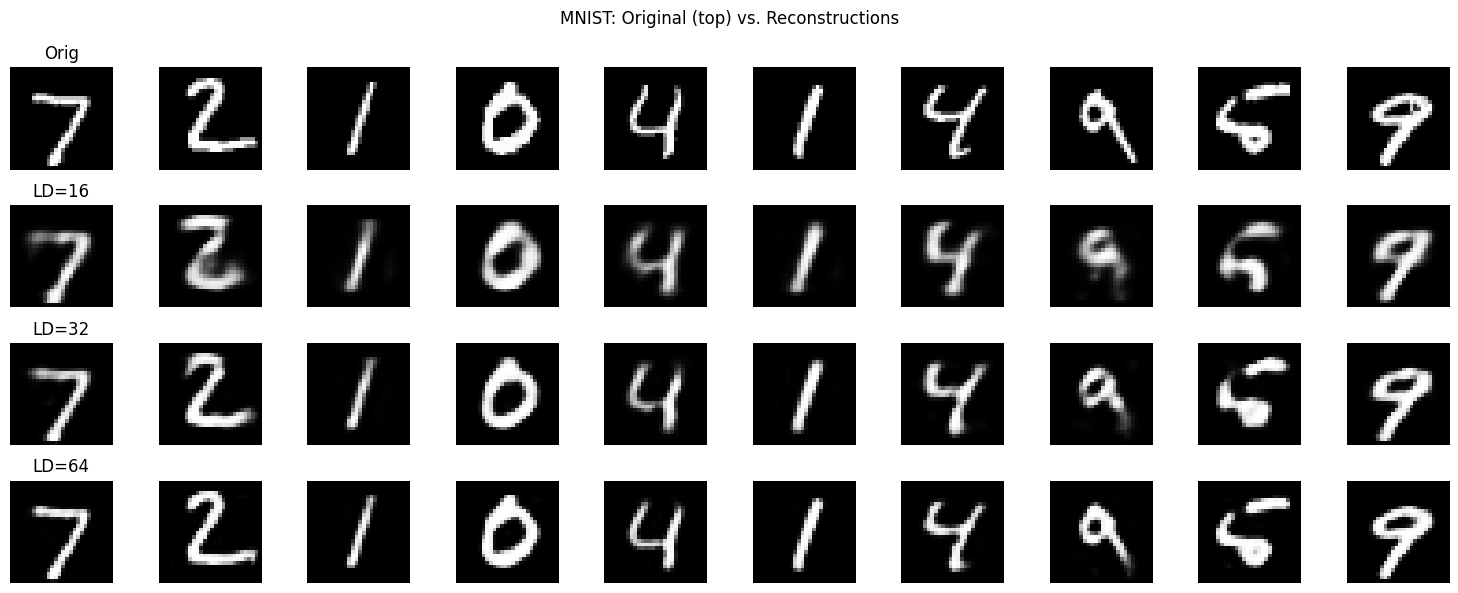


Final validation losses:
Latent dim 16: 0.1281
Latent dim 32: 0.0922
Latent dim 64: 0.0731


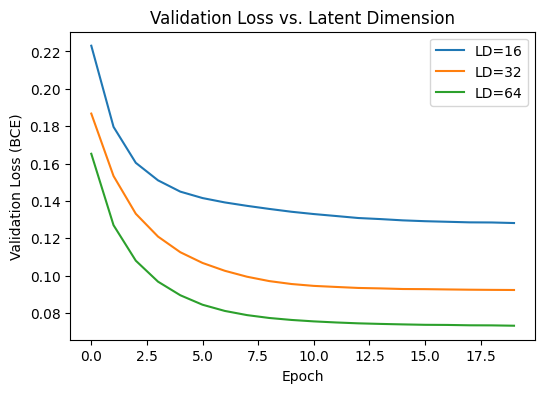

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the MNIST dataset and normalize to [0, 1]
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Flatten 28x28 images to 784‑dim vectors
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)


def build_autoencoder(latent_dim: int = 32) -> tf.keras.Model:
    """Builds and returns a fully‑connected autoencoder with a single hidden layer.

    Args:
        latent_dim: Size of the latent (bottleneck) representation.

    Returns:
        Compiled Keras Model ready for training.
    """
    # Encoder
    inputs = layers.Input(shape=(784,))
    encoded = layers.Dense(latent_dim, activation="relu", name="encoder_dense")(inputs)

    # Decoder
    decoded = layers.Dense(784, activation="sigmoid", name="decoder_dense")(encoded)

    # Autoencoder model
    autoencoder = models.Model(inputs, decoded, name=f"autoencoder_ld{latent_dim}")
    autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
    return autoencoder


# 2‑3. Train autoencoders with different latent dimensions
latent_dims = [16, 32, 64]
histories = {}
recons = {}

for ld in latent_dims:
    print(f"\nTraining autoencoder with latent_dim = {ld} …")
    ae = build_autoencoder(ld)
    histories[ld] = ae.fit(
        x_train,
        x_train,
        epochs=20,
        batch_size=256,
        shuffle=True,
        validation_data=(x_test, x_test),
        verbose=1,
    )
    # Store reconstructions for the first 10 test images
    recons[ld] = ae.predict(x_test[:10], verbose=0)

# 4. Plot original vs. reconstructed images
n = 10  # how many digits to display
rows = len(latent_dims) + 1
plt.figure(figsize=(n * 1.5, rows * 1.5))

# First row: originals
for i in range(n):
    ax = plt.subplot(rows, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Orig" if i == 0 else "")
    plt.axis("off")

# Subsequent rows: reconstructions per latent_dim
for r, ld in enumerate(latent_dims, start=1):
    for i in range(n):
        ax = plt.subplot(rows, n, r * n + i + 1)
        plt.imshow(recons[ld][i].reshape(28, 28), cmap="gray")
        if i == 0:
            plt.title(f"LD={ld}")
        plt.axis("off")

plt.suptitle("MNIST: Original (top) vs. Reconstructions")
plt.tight_layout()
plt.show()

# 5. Simple quantitative comparison of reconstruction loss
print("\nFinal validation losses:")
for ld in latent_dims:
    val_loss = histories[ld].history["val_loss"][-1]
    print(f"Latent dim {ld:>2}: {val_loss:.4f}")

# Optional: plot loss curves
plt.figure(figsize=(6, 4))
for ld in latent_dims:
    plt.plot(histories[ld].history["val_loss"], label=f"LD={ld}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (BCE)")
plt.title("Validation Loss vs. Latent Dimension")
plt.legend()
plt.show()
